In [18]:
# imports
import pandas as pd
import numpy as np

from impute_transform import ImputeTransform
import model_metrics

from xgboost import XGBClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

from fancyimpute import *

In [2]:
train_data = pd.read_csv('data/train_data.csv')

In [47]:
train_data_small = train_data.sample(n=400)
X = train_data_small.drop(columns=['DX','DXSUB'])
y = train_data_small['DX'].map({3:1, 1:0})
y_sub = train_data_small['DXSUB']

# Supervised Learning

This data is acquired from the **ADHD Research Lab** at the Oregon Health and Science University. It contains 901 subjects from the first year of a longitudinal study. The data is de-identified. It has 35 features and two target variables.

In this research project, I explore the differences in model performance.

## General Model Exploration

Running cross-validation on four models: Logistic Regression, Random Forest, Gradient Boosting, and XGBoost, on four different sets of data:
 - All features, Target = DX
 - All features, Target = DXSUB
 - TMCQ features only, Target = DX
 - Neuropsych features only, Target = DX

### Pipeline Creation

In [48]:
log_reg_clf = make_pipeline(ImputeTransform(strategy=SimpleFill()),
                        LogisticRegression(random_state=56))

rf_clf = make_pipeline(ImputeTransform(strategy=SimpleFill()),
                       RandomForestClassifier(n_jobs=-1, random_state=56))

gb_clf = make_pipeline(ImputeTransform(strategy=SimpleFill()),
                       GradientBoostingClassifier(random_state=56))

xgb_clf = make_pipeline(ImputeTransform(strategy=SimpleFill()),
                        XGBClassifier(max_depth=3, learning_rate=0.1,
                        random_state=56))

In [49]:
scoring_list = ['accuracy', 'roc_auc', 'neg_log_loss']

classifier_list = [log_reg_clf, rf_clf, gb_clf, xgb_clf]
classifier_name = ['LogReg', 'RandomForest', 'GradientBoosting', 'XGB']

metrics_of_interest = ['fit_time', 'score_time', 'test_accuracy',
                       'test_neg_log_loss', 'test_roc_auc']

## All Features, Target = DX

In [50]:
metric_dx_df = model_metrics.get_metrics(X, y,
                                classifier_list, classifier_name,
                                scoring_list, metrics_of_interest,
                                n_folds=2)

In [51]:
metric_dx_df

,fit_time,score_time,test_accuracy,test_neg_log_loss,test_roc_auc
LogReg,0.00432849,0.0050925,0.91,-0.241758,0.964339
RandomForest,0.119562,0.330641,0.925,-0.385883,0.959352
GradientBoosting,0.0768563,0.00581264,0.94,-0.265917,0.974314
XGB,0.0299087,0.00632906,0.9375,-0.202153,0.974421


## All Features, Target = DXSUB

In [68]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer

In [69]:
def multiclass_roc_auc_score(truth, pred, average="macro"):

    lb = LabelBinarizer()
    lb.fit(truth)

    truth = lb.transform(truth)
    pred = lb.transform(pred)

    return roc_auc_score(truth, pred, average=average)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y_sub, test_size=0.33, random_state=56)

In [71]:
log_reg_clf = make_pipeline(ImputeTransform(strategy=SimpleFill()),
                        LogisticRegression(random_state=56))

In [72]:
log_reg_clf.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('imputetransform', <impute_transform.ImputeTransform object at 0x7f29c71defd0>), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=56, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [ ]:
log_reg_clf.pre

CV on LogReg, RF, GB, XGB for:
  - DX
  - DXSUB
  - TMCQ
  - Neuropsych

Visualizations, model selection, opinions

Tune xgb for Dx

## Logistic Model Metrics Visualization

In [ ]:
X_train_DX = train_data.drop(columns=['DX','DXSUB'])
y_train_DX = train_data['DX']

In [ ]:
X_train_small, X_test_small, y_train_small, y_test_small = train_test_split(
                    X_train_DX, y_train_DX, test_size=0.2, random_state=56)

In [ ]:
logmod = LogisticRegression()
logmod.fit(impute_data(X_train_small.values), y_train_small)

In [ ]:
pred_prob_dx = logmod.predict_proba(impute_data(X_test_small.values))

In [ ]:
prob_dx = logmod.predict(impute_data(X_test_small.values))

In [ ]:
len(pred_prob_dx[:,0])

In [ ]:
def make_jitter(data, jitter=0.1):
    return np.random.uniform(-jitter, jitter, size=data.shape)

In [ ]:
fig, ax = plt.subplots(figsize=(10,2))

_ = ax.scatter(pred_prob_dx[:,0], make_jitter(pred_prob_dx[:,0]), c=np.vectorize(dx_dict.get)(y_test_small),
           s=40, alpha=0.5)
_ = ax.set_xlim(0,1)
_ = ax.set_title('Predicted Probability of Positive vs Negative Classes')

In [ ]:
fpr, tpr, thresholds = roc_curve(y_test_small, prob_dx, pos_label=3, drop_intermediate=False)
roc_auc = auc(fpr, tpr)

In [ ]:
plt.plot(fpr, tpr)

# Classification Metrics

I created logistic regression, random forest, and gradient boosting models. I want to see the MSE and accuracy on train/test, cross-validated (k-fold=10), when predicting DX, and when predicting DXSUB.

In [ ]:
#train_data = pd.read_csv('data/train_data.csv')

In [ ]:
#%%capture
#classifier_metrics = run_classifiers(train_data)

In [ ]:
#with open('classifier_metrics.pkl', 'wb') as f:
    #pickle.dump(classifier_metrics, f)

In [ ]:
classification_metrics = pickle.load(open("classifier_metrics.pkl", "rb"))

In [ ]:
#[clf][pred][metric][train/test]
# Logistic Regression
lr_dx_mse_train = np.mean(classification_metrics[0][0][0][0])
lr_dx_mse_test = np.mean(classification_metrics[0][0][0][1])
lr_dx_acc_train = np.mean(classification_metrics[0][0][1][0])
lr_dx_acc_test = np.mean(classification_metrics[0][0][1][1])

lr_dxsub_mse_train = np.mean(classification_metrics[0][1][0][0])
lr_dxsub_mse_test = np.mean(classification_metrics[0][1][0][1])
lr_dxsub_acc_train = np.mean(classification_metrics[0][1][1][0])
lr_dxsub_acc_test = np.mean(classification_metrics[0][1][1][1])

# Random Forest
rf_dx_mse_train = np.mean(classification_metrics[1][0][0][0])
rf_dx_mse_test = np.mean(classification_metrics[1][0][0][1])
rf_dx_acc_train = np.mean(classification_metrics[1][0][1][0])
rf_dx_acc_test = np.mean(classification_metrics[1][0][1][1])

rf_dxsub_mse_train = np.mean(classification_metrics[1][1][0][0])
rf_dxsub_mse_test = np.mean(classification_metrics[1][1][0][1])
rf_dxsub_acc_train = np.mean(classification_metrics[1][1][1][0])
rf_dxsub_acc_test = np.mean(classification_metrics[1][1][1][1])

# Gradient Boosting
gb_dx_mse_train = np.mean(classification_metrics[2][0][0][0])
gb_dx_mse_test = np.mean(classification_metrics[2][0][0][1])
gb_dx_acc_train = np.mean(classification_metrics[2][0][1][0])
gb_dx_acc_test = np.mean(classification_metrics[2][0][1][1])

gb_dxsub_mse_train = np.mean(classification_metrics[2][1][0][0])
gb_dxsub_mse_test = np.mean(classification_metrics[2][1][0][1])
gb_dxsub_acc_train = np.mean(classification_metrics[2][1][1][0])
gb_dxsub_acc_test = np.mean(classification_metrics[2][1][1][1])

In [ ]:
# Make dataframes
metrics_dx_dict = {'DX_acc_train': [lr_dx_acc_train, rf_dx_acc_train, gb_dx_acc_train],
                   'DX_acc_test': [lr_dx_acc_test, rf_dx_acc_test, gb_dx_acc_test],
                   'DX_mse_train': [lr_dx_mse_train, rf_dx_mse_train, gb_dx_mse_train],
                   'DX_mse_test': [lr_dx_mse_test, rf_dx_mse_test, gb_dx_mse_test]}

metrics_DX = pd.DataFrame(data=metrics_dx_dict,
                          columns=['DX_acc_train', 'DX_acc_test', 'DX_mse_train', 'DX_mse_test'],
                          index=['LogReg', 'RandomForest', 'GradBoost'])

In [ ]:
metrics_dxsub_dict = {'DXSUB_acc_train': [lr_dxsub_acc_train, rf_dxsub_acc_train, gb_dxsub_acc_train],
                   'DXSUB_acc_test': [lr_dxsub_acc_test, rf_dxsub_acc_test, gb_dxsub_acc_test],
                   'DXSUB_mse_train': [lr_dxsub_mse_train, rf_dxsub_mse_train, gb_dxsub_mse_train],
                   'DXSUB_mse_test': [lr_dxsub_mse_test, rf_dxsub_mse_test, gb_dxsub_mse_test]}

metrics_DXSUB = pd.DataFrame(data=metrics_dxsub_dict,
                             columns=['DXSUB_acc_train', 'DXSUB_acc_test', 'DXSUB_mse_train', 'DXSUB_mse_test'],
                             index=['LogReg', 'RandomForest', 'GradBoost'])

In [ ]:
metrics_DX.round(3)

In [ ]:
metrics_DXSUB.round(3)

# Neuropsych vs TMCQ

Now that I've evaluated models on all the data, I want to check out what accuracy and mse looks like for models run JUST on neuropsych, and JUST on TMCQ.

I'll use the same exact procedure as above, just with different X matrices.

In [ ]:
train_data = pd.read_csv('data/train_data.csv')

In [ ]:
X_TMCQ = train_data[['Y1_P_TMCQ_ACTIVCONT', 'Y1_P_TMCQ_ACTIVITY', 'Y1_P_TMCQ_AFFIL',
       'Y1_P_TMCQ_ANGER', 'Y1_P_TMCQ_FEAR', 'Y1_P_TMCQ_HIP',
       'Y1_P_TMCQ_IMPULS', 'Y1_P_TMCQ_INHIBIT', 'Y1_P_TMCQ_SAD',
       'Y1_P_TMCQ_SHY', 'Y1_P_TMCQ_SOOTHE', 'Y1_P_TMCQ_ASSERT',
       'Y1_P_TMCQ_ATTFOCUS', 'Y1_P_TMCQ_LIP', 'Y1_P_TMCQ_PERCEPT',
       'Y1_P_TMCQ_DISCOMF', 'Y1_P_TMCQ_OPENNESS', 'Y1_P_TMCQ_SURGENCY',
       'Y1_P_TMCQ_EFFCONT', 'Y1_P_TMCQ_NEGAFFECT']]

In [ ]:
X_TMCQ.shape

In [ ]:
X_neuro = train_data[['STOP_SSRTAVE_Y1', 'DPRIME1_Y1', 'DPRIME2_Y1', 'SSBK_NUMCOMPLETE_Y1',
       'SSFD_NUMCOMPLETE_Y1', 'V_Y1', 'Y1_CLWRD_COND1', 'Y1_CLWRD_COND2',
       'Y1_DIGITS_BKWD_RS', 'Y1_DIGITS_FRWD_RS', 'Y1_TRAILS_COND2',
       'Y1_TRAILS_COND3', 'CW_RES', 'TR_RES', 'Y1_TAP_SD_TOT_CLOCK']]

In [ ]:
y_all = train_data[['DX', 'DXSUB']]

In [ ]:
# Must drop subjects where ALL data is missing, due to matrix factorixation imputation
X_TMCQ_nonull = X_TMCQ.dropna(how='all')
X_neuro_nonull = X_neuro.dropna(how='all')

In [ ]:
%%capture
TMCQ_dx, TMCQ_dxsub = run_classifiers(X_TMCQ_nonull, y_all)

In [ ]:
TMCQ_dx

In [ ]:
TMCQ_dxsub

In [ ]:
%%capture
neuro_dx, neuro_dxsub = run_classifiers(X_neuro_nonull, y_all)

In [ ]:
neuro_dx

In [ ]:
neuro_dxsub

# Building Pipeline for CV 

I just remembered that sklearn.pipeline is a thing.
So, I'm going to build that so cross-validation and multiple metrics are easier!

From sklearn:
```
from sklearn.pipeline import make_pipeline
clf = make_pipeline(preprocessing.StandardScaler(), svm.SVC(C=1))
cross_val_score(clf, iris.data, iris.target, cv=cv)
...                                                 
array([ 0.97...,  0.93...,  0.95...])
```

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from fancyimpute import MICE
from impute_transform import ImputeTransform

In [ ]:
train_data = pd.read_csv('data/train_data.csv')
train_data_small = train_data.sample(n=100)
X = train_data_small.drop(columns=['DX','DXSUB'])
y = train_data_small['DX'].map({3:1,1:0})

In [ ]:
clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()), LogisticRegression(random_state=56))

In [ ]:
scoring = ['accuracy', 'roc_auc', 'neg_log_loss']

In [ ]:
scores = cross_validate(clf, X, y, scoring=scoring, cv=2, return_train_score=True)

In [ ]:
scores

### Final Thoughts for the day


My brain is pretty fried, so I'm gonna call it a night.

But here's next steps for tomorrow:
- Get this cross_validate function working for log_reg, rf, gb, and xgb
- Get this cross_validate function working for DXSUB
 - cause of the multiclass problem and all that
- Explore TMCQ and neuropsych more
 - The metrics were quite bad on these! And logistic regression actually performed better test-wise than RF and GB!
- Discuss next steps with Matt
 - Clustering ideas
 - How to approach hyperparam tuning

#### Clustering Ideas

[Subtyping ADHD Using Tempermant Dimensions](https://jamanetwork.com/journals/jamapsychiatry/fullarticle/1885709)

The above is a paper written by my boss (Dr. Karalunas) that utilized community detection analysis on the Temperment in Middle Childhood Questionnaire (TMCQ).
They had 437 children and used the TMCQ from year 1. 
They specifically used the [Fast Greedy algorithm](https://arxiv.org/abs/cond-mat/0408187) and found 3 profiles of children, which they labeled as "mild", "surgent", and "irritable".

I was thinking of trying to replicate this analysis on the full 901 dataset ([community detection in python](https://yoyoinwanderland.github.io/2017/08/08/Community-Detection-in-Python/)).
Then, I was thinking of trying different clustering algorithms to see if the same profiles seem to exist.

It'd basically be a study in reproducability.

They used physiological and MRI data to externally validate these profiles, which I don't really have. But I might be able to glean something interesting from the neuropsych data? Maybe? IDK. Focus on "are the profiles there".

# Pipeline Continuing

I want to test the following models:
- Logistic Regression
- Random Forest
- Gradient Boosting
- XGBoost

With the following metrics:
- ROC AUC
- Accuracy
- Log Loss

On the following data:
- DX
- DXSUB
- Neuropsych
- TMCQ

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from collections import defaultdict
from sklearn.metrics import make_scorer, accuracy_score, log_loss
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
from impute_transform import ImputeTransform
from xgboost import XGBClassifier

# Running the models for real

In [ ]:
train_data = pd.read_csv('data/train_data.csv')
X = train_data.drop(columns=['DX','DXSUB'])
y = train_data['DX'].map({3:1,1:0})

In [ ]:
log_reg_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                        LogisticRegression(random_state=56))

rf_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                       RandomForestClassifier(n_jobs=-1, random_state=56))

gb_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                       GradientBoostingClassifier(random_state=56))

xgb_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                        XGBClassifier(max_depth=3, learning_rate=0.1,
                        random_state=56))

In [ ]:
scoring = ['accuracy', 'roc_auc', 'neg_log_loss']

In [ ]:
classifier_list = [log_reg_clf, rf_clf, gb_clf, xgb_clf]
classifier_name = ['LogReg', 'RandomForest', 'GradientBoosting', 'XGB']

In [ ]:
%%capture
classifier_metrics = {}
for clf, name in zip(classifier_list, classifier_name):
    scores = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=False)
    classifier_metrics[name] = scores

In [ ]:
classifier_metrics

In [ ]:
for classifier, dictionary in classifier_metrics.items():
    for metric, score in classifier_metrics[classifier].items():
        classifier_metrics[classifier][metric] = np.mean(score)

In [ ]:
name_of_metrics = ['fit_time', 'score_time', 'test_accuracy',
                   'test_neg_log_loss', 'test_roc_auc']

In [ ]:
metrics_df = pd.DataFrame(data=None,
                          index=classifier_name,
                          columns=name_of_metrics)

In [ ]:
for clf in classifier_name:
    for metric in name_of_metrics:
        metrics_df[metric].loc[clf] = classifier_metrics[clf][metric]

In [ ]:
metrics_df

In [ ]:
# testing on holdout to see if its somewhat similar or
# super off like it was for tmcq...
holdout_data = pd.read_csv('data/holdout_data.csv')
X_test = holdout_data.drop(columns=['DX','DXSUB'])
y_test = holdout_data['DX'].map({3:1,1:0})
# yep, it worked there...

XGB and LogReg have the best AUC scores, and log_loss scores. Even though GB had the highest test accuracy, I think XGB and LogReg are the models to explore.

### TMCQ

I also want to run this on Neuropsych and TMCQ data. It seemed like last time, RF and GB overfit - but XGBoost has regularization so this might mediate that problem.

In [ ]:
X_TMCQ = train_data[['Y1_P_TMCQ_ACTIVCONT', 'Y1_P_TMCQ_ACTIVITY', 'Y1_P_TMCQ_AFFIL',
       'Y1_P_TMCQ_ANGER', 'Y1_P_TMCQ_FEAR', 'Y1_P_TMCQ_HIP',
       'Y1_P_TMCQ_IMPULS', 'Y1_P_TMCQ_INHIBIT', 'Y1_P_TMCQ_SAD',
       'Y1_P_TMCQ_SHY', 'Y1_P_TMCQ_SOOTHE', 'Y1_P_TMCQ_ASSERT',
       'Y1_P_TMCQ_ATTFOCUS', 'Y1_P_TMCQ_LIP', 'Y1_P_TMCQ_PERCEPT',
       'Y1_P_TMCQ_DISCOMF', 'Y1_P_TMCQ_OPENNESS', 'Y1_P_TMCQ_SURGENCY',
       'Y1_P_TMCQ_EFFCONT', 'Y1_P_TMCQ_NEGAFFECT']]

In [ ]:
X_TMCQ_nonull = X_TMCQ[X_TMCQ.isnull().sum(axis=1) == 0]
y_TMCQ_nonull = y[X_TMCQ.isnull().sum(axis=1) == 0]

In [ ]:
# Don't need imputation for TMCQ because I removed NaNs
log_reg_clf = LogisticRegression(random_state=56)

rf_clf = RandomForestClassifier(n_jobs=-1, random_state=56)

gb_clf = GradientBoostingClassifier(random_state=56)

xgb_clf = XGBClassifier(max_depth=3, learning_rate=0.1,
                        random_state=56)

In [ ]:
classifier_list = [log_reg_clf, rf_clf, gb_clf, xgb_clf]
classifier_name = ['LogReg', 'RandomForest', 'GradientBoosting', 'XGB']

In [ ]:
%%capture
classifier_metrics_TMCQ = {}
for clf, name in zip(classifier_list, classifier_name):
    scores = cross_validate(clf, X_TMCQ_nonull, y_TMCQ_nonull, scoring=scoring, cv=5, return_train_score=True)
    classifier_metrics_TMCQ[name] = scores

In [ ]:
for classifier, dictionary in classifier_metrics_TMCQ.items():
    for metric, score in classifier_metrics_TMCQ[classifier].items():
        classifier_metrics_TMCQ[classifier][metric] = np.mean(score)

In [ ]:
name_of_metrics = ['fit_time', 'score_time', 'test_accuracy',
                   'test_neg_log_loss', 'test_roc_auc']

In [ ]:
metrics_df_TMCQ = pd.DataFrame(data=None,
                          index=classifier_name,
                          columns=name_of_metrics)

In [ ]:
for clf in classifier_name:
    for metric in name_of_metrics:
        metrics_df_TMCQ[metric].loc[clf] = classifier_metrics_TMCQ[clf][metric]

In [ ]:
metrics_df_TMCQ

In [ ]:
# testing on holdout to see if its somewhat similar
X_test_TMCQ = holdout_data[['Y1_P_TMCQ_ACTIVCONT', 'Y1_P_TMCQ_ACTIVITY', 'Y1_P_TMCQ_AFFIL',
       'Y1_P_TMCQ_ANGER', 'Y1_P_TMCQ_FEAR', 'Y1_P_TMCQ_HIP',
       'Y1_P_TMCQ_IMPULS', 'Y1_P_TMCQ_INHIBIT', 'Y1_P_TMCQ_SAD',
       'Y1_P_TMCQ_SHY', 'Y1_P_TMCQ_SOOTHE', 'Y1_P_TMCQ_ASSERT',
       'Y1_P_TMCQ_ATTFOCUS', 'Y1_P_TMCQ_LIP', 'Y1_P_TMCQ_PERCEPT',
       'Y1_P_TMCQ_DISCOMF', 'Y1_P_TMCQ_OPENNESS', 'Y1_P_TMCQ_SURGENCY',
       'Y1_P_TMCQ_EFFCONT', 'Y1_P_TMCQ_NEGAFFECT']]
y_test_TMCQ = holdout_data['DX'].map({3:1,1:0})

X_test_TMCQ_nonull = X_test_TMCQ[X_test_TMCQ.isnull().sum(axis=1) == 0]
y_test_TMCQ_nonull = y_test[X_test_TMCQ.isnull().sum(axis=1) == 0]
# also get similar results! yay!

### Neuropsych

In [ ]:
X_neuro = train_data[['STOP_SSRTAVE_Y1', 'DPRIME1_Y1', 'DPRIME2_Y1', 'SSBK_NUMCOMPLETE_Y1',
       'SSFD_NUMCOMPLETE_Y1', 'V_Y1', 'Y1_CLWRD_COND1', 'Y1_CLWRD_COND2',
       'Y1_DIGITS_BKWD_RS', 'Y1_DIGITS_FRWD_RS', 'Y1_TRAILS_COND2',
       'Y1_TRAILS_COND3', 'CW_RES', 'TR_RES', 'Y1_TAP_SD_TOT_CLOCK']]

In [ ]:
X_neuro_nonull = X_neuro[X_neuro.isnull().sum(axis=1) != X_neuro.shape[1]]
y_neuro_nonull = y[X_neuro.isnull().sum(axis=1) != X_neuro.shape[1]]

In [ ]:
log_reg_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                        LogisticRegression(random_state=56))

rf_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                       RandomForestClassifier(n_jobs=-1, random_state=56))

gb_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                       GradientBoostingClassifier(random_state=56))

xgb_clf = make_pipeline(ImputeTransform(strategy=MatrixFactorization()),
                        XGBClassifier(max_depth=3, learning_rate=0.1,
                        random_state=56))

In [ ]:
classifier_list = [log_reg_clf, rf_clf, gb_clf, xgb_clf]
classifier_name = ['LogReg', 'RandomForest', 'GradientBoosting', 'XGB']

In [ ]:
%%capture
classifier_metrics_neuro = {}
for clf, name in zip(classifier_list, classifier_name):
    scores = cross_validate(clf,
                            X_neuro_nonull, y_neuro_nonull,
                            scoring=scoring, cv=5,
                            return_train_score=True)
    classifier_metrics_neuro[name] = scores

In [ ]:
for classifier, dictionary in classifier_metrics_neuro.items():
    for metric, score in classifier_metrics_neuro[classifier].items():
        classifier_metrics_neuro[classifier][metric] = np.mean(score)

In [ ]:
name_of_metrics = ['fit_time', 'score_time', 'test_accuracy',
                   'test_neg_log_loss', 'test_roc_auc']

In [ ]:
metrics_df_neuro = pd.DataFrame(data=None,
                          index=classifier_name,
                          columns=name_of_metrics)

In [ ]:
for clf in classifier_name:
    for metric in name_of_metrics:
        metrics_df_neuro[metric].loc[clf] = classifier_metrics_neuro[clf][metric]

In [ ]:
metrics_df_neuro

In [ ]:
# testing on holdout to see if its somewhat similar
X_test_neuro = holdout_data[['STOP_SSRTAVE_Y1', 'DPRIME1_Y1', 'DPRIME2_Y1', 'SSBK_NUMCOMPLETE_Y1',
       'SSFD_NUMCOMPLETE_Y1', 'V_Y1', 'Y1_CLWRD_COND1', 'Y1_CLWRD_COND2',
       'Y1_DIGITS_BKWD_RS', 'Y1_DIGITS_FRWD_RS', 'Y1_TRAILS_COND2',
       'Y1_TRAILS_COND3', 'CW_RES', 'TR_RES', 'Y1_TAP_SD_TOT_CLOCK']]
y_test_neuro = holdout_data['DX'].map({3:1,1:0})

X_test_neuro_nonull = X_test_neuro[X_test_neuro.isnull().sum(axis=1) != X_test_neuro.shape[1]]
y_test_neuro_nonull = y_test_neuro[X_test_neuro.isnull().sum(axis=1) != X_test_neuro.shape[1]]
# yep, looks good

# Conclusions

Log Reg and XGB are the most robust and accurate models. RF and GB can be prone to overfitting, but XGB fixes this problem with regularization.

So, I will focus on parameter optimization of LogisticRegression and XGB.

# Parameter Tuning for XGBoost

Following the guidelines set out here: [Complete Guide to Parameter Tuning in XGBoost](https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/)

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
from model_metrics import *
from fancyimpute import *
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from impute_transform import ImputeTransform
from sklearn.pipeline import Pipeline

In [2]:
train_data = pd.read_csv('data/train_data.csv')
train_data_small = train_data.sample(n=400)
X = train_data_small.drop(columns=['DX','DXSUB'])
y = train_data_small['DX'].map({3:1,1:0})

In [20]:
impute = ImputeTransform(strategy=MICE())
clf = XGBClassifier(
                  learning_rate = 0.1,
                  n_estimators = 1000,
                  max_depth = 5,
                  min_child_weight = 1,
                  gamma = 0,
                  subsample = 0.8,
                  colsample_bytree = 0.8,
                  scale_pos_weight=1,
                  objective = 'binary:logistic',
                  n_jobs = -1,
                  random_state=56)

In [21]:
steps = [('impute_transform', impute),
         ('xgboost', clf)]

pipeline = Pipeline(steps)

## Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In [22]:
param_test1 = {'xgboost__n_estimators': range(20,101,10)}

gsearch1 = GridSearchCV(pipeline,
                        param_grid=param_test1,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [23]:
%%capture
gsearch1.fit(X, y)

In [38]:
print(gsearch1.best_params_, gsearch1.best_score_)
best_n_estimators = gsearch1.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

{'xgboost__n_estimators': 70} 0.974950783526


## Step 2: Tune max_depth and min_child_weight

In [39]:
param_test2 = {'xgboost__max_depth': range(3,10,2),
               'xgboost__min_child_weight': range(1,6,2)}

gsearch2 = GridSearchCV(pipeline,
                        param_grid=param_test2,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [40]:
%%capture
gsearch2.fit(X, y)

In [41]:
print(gsearch2.best_params_, gsearch2.best_score_)

{'xgboost__max_depth': 3, 'xgboost__min_child_weight': 1} 0.97619655091


### Step 2b: Find optimum values

In [45]:
param_test2a = {'xgboost__max_depth': [1,2,3,4],
                'xgboost__min_child_weight': [1,2,3]}
gsearch2a = GridSearchCV(pipeline,
                         param_grid=param_test2a,
                         scoring='roc_auc',
                         iid=False, cv=3)

In [46]:
%%capture
gsearch2a.fit(X, y)

In [47]:
print(gsearch2a.best_params_, gsearch2a.best_score_)

{'xgboost__max_depth': 1, 'xgboost__min_child_weight': 2} 0.975966611544


In [49]:
# Set the new parameters
best_max_depth = gsearch2a.best_params_['xgboost__max_depth']
best_child_weight = gsearch2a.best_params_['xgboost__min_child_weight']
_ = pipeline.set_params(xgboost__max_depth=best_max_depth,
                        xgboost__min_child_weight=best_child_weight)

## Step 3: Tune gamma

In [50]:
param_test3 = {'xgboost__gamma': [i/10.0 for i in range(0,5)]}
gsearch3 = GridSearchCV(pipeline,
                        param_grid=param_test3,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [51]:
%%capture
gsearch3.fit(X, y)

In [52]:
print(gsearch3.best_params_, gsearch3.best_score_)

{'xgboost__gamma': 0.3} 0.977002913615


In [54]:
# Set the new parameters
best_gamma = gsearch3.best_params_['xgboost__gamma']
_ = pipeline.set_params(xgboost__gamma=best_max_depth)

### Step 3b: Re-calibrate n_estimators for updated parameters

In [55]:
param_test3b = {'xgboost__n_estimators': range(20,101,10)}

gsearch3b = GridSearchCV(pipeline,
                         param_grid=param_test3b,
                         scoring='roc_auc',
                         iid=False, cv=3)

In [56]:
%%capture
gsearch3b.fit(X, y)

In [57]:
print(gsearch3b.best_params_, gsearch3b.best_score_)

{'xgboost__n_estimators': 90} 0.97613512875


In [58]:
best_n_estimators = gsearch3b.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

## Step 4: Tune subsample and colsample_bytree

In [ ]:
# probably skippable

## Step 5: Tuning Regularization Parameters

In [ ]:
# probably skippable

## Step 6: Reducing Learning Rate, Add Trees

In [59]:
_ = pipeline.set_params(xgboost__learning_rate=0.01)

In [61]:
param_test6 = {'xgboost__n_estimators': range(60,200,10)}

gsearch6 = GridSearchCV(pipeline,
                        param_grid=param_test6,
                        scoring='roc_auc',
                        iid=False, cv=3)

In [62]:
%%capture
gsearch6.fit(X, y)

In [63]:
print(gsearch6.best_params_, gsearch6.best_score_)

{'xgboost__n_estimators': 190} 0.976920229939


In [71]:
best_n_estimators = gsearch6.best_params_['xgboost__n_estimators']
_ = pipeline.set_params(xgboost__n_estimators=best_n_estimators)

## Step 7: Fit full model, examine feature importances

In [72]:
pipeline.fit(X, y)

[MICE] Completing matrix with shape (400, 35)
[MICE] Starting imputation round 1/110, elapsed time 0.001
[MICE] Starting imputation round 2/110, elapsed time 0.011
[MICE] Starting imputation round 3/110, elapsed time 0.021
[MICE] Starting imputation round 4/110, elapsed time 0.032
[MICE] Starting imputation round 5/110, elapsed time 0.042
[MICE] Starting imputation round 6/110, elapsed time 0.052
[MICE] Starting imputation round 7/110, elapsed time 0.063
[MICE] Starting imputation round 8/110, elapsed time 0.073
[MICE] Starting imputation round 9/110, elapsed time 0.083
[MICE] Starting imputation round 10/110, elapsed time 0.093
[MICE] Starting imputation round 11/110, elapsed time 0.105
[MICE] Starting imputation round 12/110, elapsed time 0.115
[MICE] Starting imputation round 13/110, elapsed time 0.126
[MICE] Starting imputation round 14/110, elapsed time 0.136
[MICE] Starting imputation round 15/110, elapsed time 0.146
[MICE] Starting imputation round 16/110, elapsed time 0.157
[MI

Pipeline(memory=None,
     steps=[('impute_transform', <impute_transform.ImputeTransform object at 0x7f42ec34f7f0>), ('xgboost', XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1, learning_rate=0.01, max_delta_step=0,
       max_depth=1, min_child_weight=2, missing=None, n_estimators=190,
       n_jobs=-1, nthread=None, objective='binary:logistic',
       random_state=56, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=None, silent=True, subsample=0.8))])

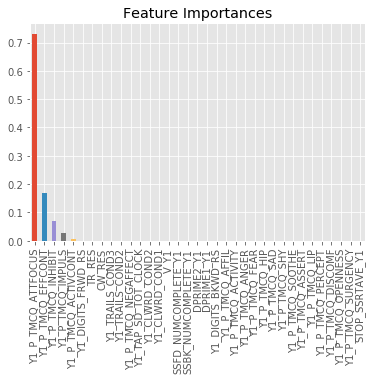

In [93]:
feat_imp = pd.Series(pipeline.steps[1][1].feature_importances_,index=X.columns).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')